In [6]:
from pathlib import Path
import json

import polars as pl
import numpy as np

In [7]:
events_by_id = {}


# just fill events_by_id from parsed data
events_dir = Path('meetup_parser/simple/meetup_parsing/nl--Amsterdam/')
for event_dir in events_dir.iterdir():
    if not event_dir.is_dir():
        continue

    with open(event_dir / 'event') as event_fd:
        event = json.loads(event_fd.read())
        event_attendees = {
            attendee_file.name: json.loads(attendee_file.open().read())
            for attendee_file in (event_dir / 'attendees').iterdir()
        }
        
        events_by_id[event['id']] = {
            'event': event,
            'attendees': event_attendees,
        }

In [8]:
# use pre-trained vectors
embeddings_dict = {}
with open("glove.6B/glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [9]:
# text embedding with glove (first )
def get_glove_text_emb(text):
    SIZE = 300 # embedding dimensions
    
    # vec = np.zeros(SIZE).reshape((1, SIZE))
    vec = np.zeros(SIZE)
    count = 0

    # mean value of all words
    for word in text.split():
        try:
            # vec += embeddings_dict[word].reshape((1, SIZE))
            vec += embeddings_dict[word]
            count += 1
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [13]:
# example - event `300283984`
print('TITLE', events_by_id['300283984']['event']['title'])
print('START_DATE', events_by_id['300283984']['event']['event_start_dt'])
print('DESCRIPTION', events_by_id['300283984']['event']['description'])

TITLE Expand and Contract (Georg Berky) 
START_DATE 2024-05-23T18:30:00+02:00
DESCRIPTION In den letzten Jahren hat sich das Tooling in den Bereichen Continuous Integration, Continuous Delivery und Infrastructure as Code erheblich verbessert. Pipelines, Builds und Deployments bekommt man oft schon mit der Source-Verwaltung geschenkt. Man sollte meinen, dass dank der neuen Tools jedes Team sofort mit mehreren Deployments pro Stunde direkt nach Production liefern könnte. Dem ist aber nicht so - und der Grund dafür liegt meistens nicht in den Tools.

Expand and Contract ist eine Denk- und Entwicklungsweise, die essenziell ist für Continuous Delivery. In diesem Vortrag zeigt euch Georg mit viel Live Coding und ein wenig Theorie, welchen Weg er dahin genommen hat. Er beginnt mit einer Abneigung für unsichere Handarbeit und führt zu einer jederzeit unterbrech- und releasebaren Arbeitsweise, der Grundlage für Continuous Delivery.

**Georg Berky**
Georgs Handwerk und Leidenschaft ist die Progr

In [10]:
def get_attendee_descrition(topics):
    if len(topics) == 0:
        return ''
        
    attendee_descrition = 'Hello! My interests are: '
    for topic in topics:
        attendee_descrition += topic['name'] + ', '
    return attendee_descrition

In [11]:
event_1_descr_emb = get_glove_text_emb(events_by_id['300283984']['event']['description'])
event_1_attendees_embs = {
    attendee['id']: get_glove_text_emb(get_attendee_descrition(attendee['topics']))
    for attendee in events_by_id['300283984']['attendees'].values()
}

event_2_descr_emb = get_glove_text_emb(events_by_id['300305957']['event']['description'])
event_2_attendees_embs = {
    attendee['id']: get_glove_text_emb(get_attendee_descrition(attendee['topics']))
    for attendee in events_by_id['300305957']['attendees'].values()
}


In [8]:
get_glove_text_emb(events_by_id['300283984']['event']['description'])

array([ 0.14307734,  0.11066193,  0.18024852, -0.82455894, -0.49365744,
       -0.36710106,  0.40433076, -0.23387506, -0.06916531, -0.22148124,
        0.09180219, -0.00584418, -0.73805972, -0.01387209,  0.29700826,
       -0.23179562,  0.50734358,  0.30960086, -0.12484121,  0.8959057 ,
        0.01121536, -0.573968  ,  0.62532979,  0.67512365,  0.11456897,
       -0.46933505, -0.77367886, -0.02158953, -0.5026821 , -0.27527441,
        0.53840398, -0.15700982, -0.04234674,  0.62788032, -0.87588492,
       -0.22255579,  0.44907173,  0.25208182,  0.85870785,  0.37946999,
        0.29400792, -0.46475338, -0.07346013, -0.3507658 ,  0.59633403,
       -0.73882677,  0.33776086, -0.4331917 ,  0.39120368,  0.62632509])

In [12]:
from sklearn.manifold import TSNE


all_embs = np.array([
    event_1_descr_emb,
    *event_1_attendees_embs.values(),
    event_2_descr_emb,
    *event_2_attendees_embs.values(),
])

tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')
embeddings2d = tsne.fit(np.array(all_embs))

In [10]:
tsne.embedding_[0:1,0]

array([119.4662], dtype=float32)

In [13]:
event_1_attendees_count = len(event_1_attendees_embs.values())
event_2_attendees_count = len(event_2_attendees_embs.values())

event_1_data = pl.DataFrame({
    'x': tsne.embedding_[0:1,0],
    'y': tsne.embedding_[0:1,1],
    'object': 'event 2',
    'name': events_by_id['300283984']['event']['title'],
})
event_1_attendees_data = pl.DataFrame({
    'x': tsne.embedding_[1:event_1_attendees_count+1,0],
    'y': tsne.embedding_[1:event_1_attendees_count+1,1],
    'object': 'event 1 attendees',
    'name': event_1_attendees_embs.keys(),
})

event_2_data = pl.DataFrame({
    'x': tsne.embedding_[event_1_attendees_count+1:event_1_attendees_count+2,0],
    'y': tsne.embedding_[event_1_attendees_count+1:event_1_attendees_count+2,1],
    'object': 'event 1',
    'name': events_by_id['300305957']['event']['title'],
})
event_2_attendees_data = pl.DataFrame({
    'x': tsne.embedding_[event_1_attendees_count+2:,0],
    'y': tsne.embedding_[event_1_attendees_count+2:,1],
    'object': 'event 2 attendees',
    'name': event_2_attendees_embs.keys(),
})

all_points = pl.concat(
    [
        event_1_data,
        event_1_attendees_data,
        event_2_data,
        # event_2_attendees_data,
    ],
    how="vertical",
)
all_points

x,y,object,name
f32,f32,str,str
41.784939,-78.502014,"""event 2""","""Expand and Con…"
-156.688354,-326.585815,"""event 1 attend…","""1994757293"""
145.590408,-159.199127,"""event 1 attend…","""1993040306"""
-156.688354,-326.585815,"""event 1 attend…","""1993061061"""
-337.668488,83.653061,"""event 1 attend…","""1994062788"""
…,…,…,…
-337.668488,83.653061,"""event 1 attend…","""1994595427"""
-156.688354,-326.585815,"""event 1 attend…","""1993870690"""
-156.688354,-326.585815,"""event 1 attend…","""1994501266"""


In [16]:
from scipy import spatial

def find_closest_embeddings(embedding): 
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [25]:
find_closest_embeddings(get_glove_text_emb('пёс'))[:10]

['k587-1',
 'str95bb',
 'http://www.mediabynumbers.com',
 'k977-1',
 'js94bb',
 'k978-1',
 'bulletinyyy',
 'bb96',
 'mo95',
 'bdb94']

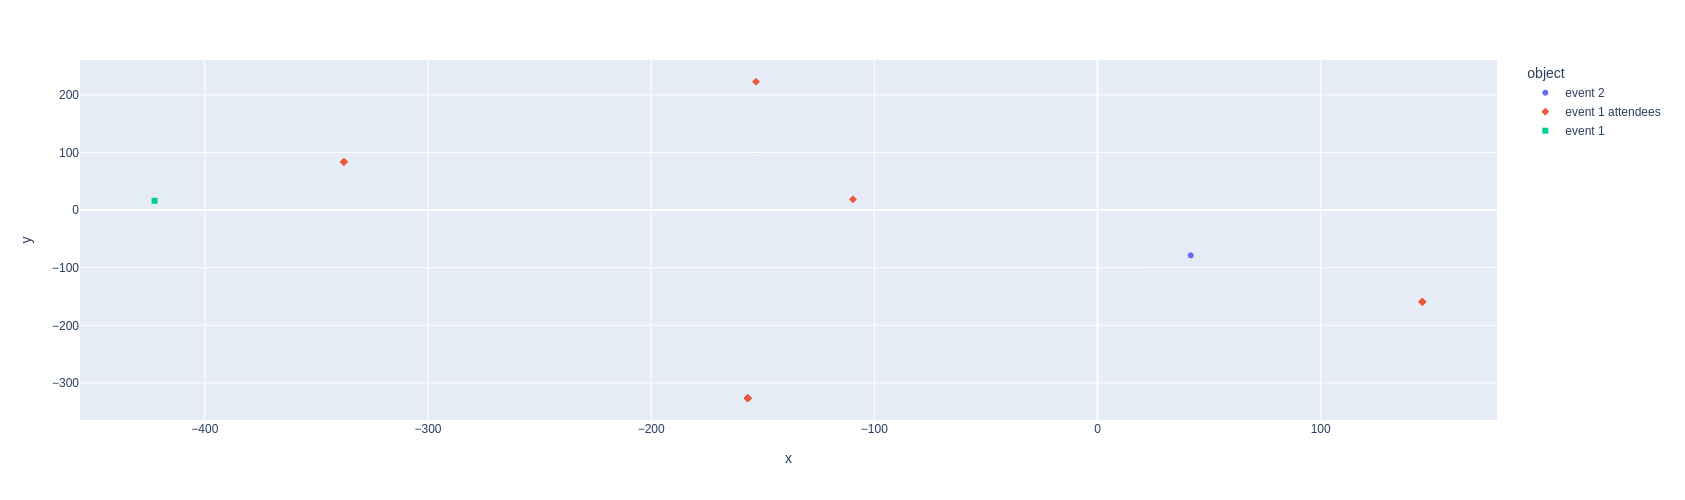

In [18]:
import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio

pio.renderers.default = 'notebook'
pyo.init_notebook_mode(connected=True)

fig = px.scatter(all_points, x='x', y='y', color="object", symbol='object', hover_data='name', width=800, height=500)
# fig = px.scatter(embeddingsdf, x='x', y='y')
# fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()

In [61]:
events_by_id['300283984']['attendees']

{'1994757293': {'id': '1994757293',
  'member_id': '249824483',
  'name': 'Garo K.',
  'topics': [],
  'membership_role': 'MEMBER',
  'membership_status': 'ACTIVE'},
 '1993040306': {'id': '1993040306',
  'member_id': '13483320',
  'name': 'Jens Bendisposto',
  'topics': [{'id': '5938', 'name': 'Экстремальное программирование'},
   {'id': '8192', 'name': 'Открытый код'},
   {'id': '15167', 'name': 'Облачные вычисления'},
   {'id': '15582', 'name': 'Веб-разработки'},
   {'id': '21549', 'name': 'Управление проектами Agile'},
   {'id': '32528', 'name': 'Компьютерное программирование'},
   {'id': '40786', 'name': 'Spring-фрэймворк'},
   {'id': '57874', 'name': 'Java'},
   {'id': '120095', 'name': 'Разработка ПО'},
   {'id': '152904', 'name': 'Scrum'},
   {'id': '263631', 'name': 'Разработка через тестирование'},
   {'id': '643822', 'name': 'Автоматизация тестирования'},
   {'id': '788002', 'name': 'Веб-технологии'},
   {'id': '1056672', 'name': 'Большие данные'},
   {'id': '1500712', 'name'

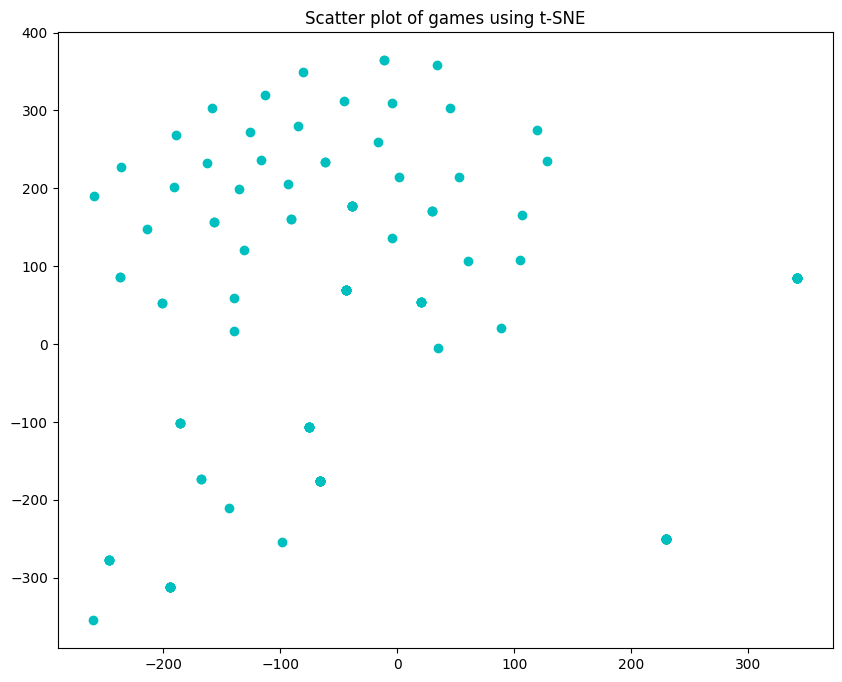

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(all_points['x'], all_points['y'], color="c")
plt.title('Scatter plot of games using t-SNE')
plt.show()